# Desafio 7: Modelo de análise das métricas RFV

## Business Understanding

### Contexto

Você foi contratado por uma empresa de e-commerce que está buscando entender melhor o comportamento de seus clientes para personalizar as suas campanhas de marketing. Para isso, a empresa disponibilizou uma base de dados em csv contendo dados sobre clientes, produtos e transações da loja realizadas entre os anos de 2010 e 2011.

Com base nesses dados, você precisa agrupar os clientes em clusters com base em seu comportamento de compra. Isso irá permitir identificar padrões e características em comum entre os clientes, como:

- Clientes que compram os mesmos produtos;
- Clientes que possuem a mesma frequência de compras;
- Clientes que gastam mais dinheiro em suas compras.

A partir desses clusters, gere insights para que a empresa possa segmentar melhor a sua base de clientes e personalizar as suas campanhas de marketing, direcionando promoções e ofertas aos clientes com base no comportamento de compras.

## SetUp

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, scale

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from yellowbrick.cluster import kelbow_visualizer

from sklearn.preprocessing import PowerTransformer

In [ ]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Understanding

### Descrição

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/DNCDados/Desafio7/data.csv', encoding='latin-1')

Acesse os dados aqui: https://www.kaggle.com/datasets/carrie1/ecommerce-data

Os dados fornecidos possuem informações de transações de compras de uma loja de e-commerce em 38 países e territórios, com mais de 4.000 clientes únicos e mais de 540.000 transações.

Atenção: as datas estão no formato MM/DD/YYYY HH:mm:ss; existem dados nulos que precisam ser tratados antes da realização da análise; por mais que os códigos de identificação sejam numéricos, o modelo não pode considerá-los como grandezas numéricas.

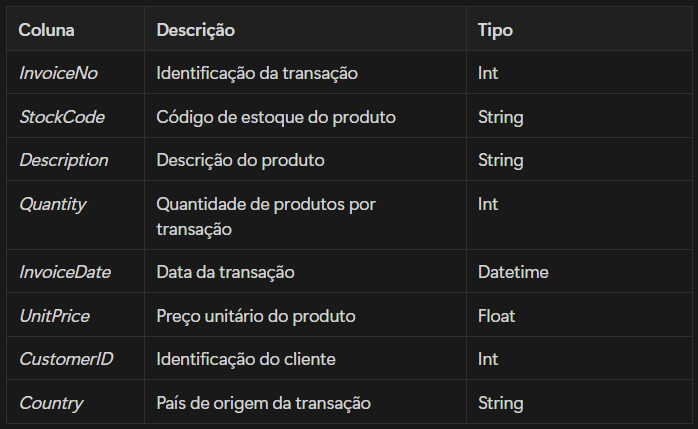

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Análise exploratória

#### Tipos de Dados

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df.InvoiceNo.sort_values()

,InvoiceNo
0,536365
1,536365
2,536365
3,536365
4,536365
...,...
540449,C581490
541541,C581499
541715,C581568
541716,C581569


Alterações necessárias:

*   InvoiceDate  -> Datetime
*   CustomerID -> int



InvoiceNo parece ter outros tipos de entradas além de somente numéricas, mas também parecem válidas.

#### Nulos

In [ ]:
df.isnull().sum().to_frame('Nulos').apply(lambda x: f'{x.values[0]} ({x.values[0]/df.shape[0]:.2%})', axis=1)

,0
InvoiceNo,0 (0.00%)
StockCode,0 (0.00%)
Description,1454 (0.27%)
Quantity,0 (0.00%)
InvoiceDate,0 (0.00%)
UnitPrice,0 (0.00%)
CustomerID,135080 (24.93%)
Country,0 (0.00%)


Quase 25% dos dados de CustomerID estão faltando. Como o objetivo é analisar o comportamento dos clientes em suas compras não faz sentido trabalhar com as linhas em que não sabemos de que clientes se tratam.

In [ ]:
df.duplicated().sum()

5268

Há algumas entradas repetidas também e considerando que essas levam informações sobre quem comprou, quando, quanto, de que produto e ainda uma descrição, podemos assumir que essas entradas são resultado de algum erro.

#### Distribuição

In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Aqui vamos analisar com foco em Quantity e UnitPrice

<Axes: >

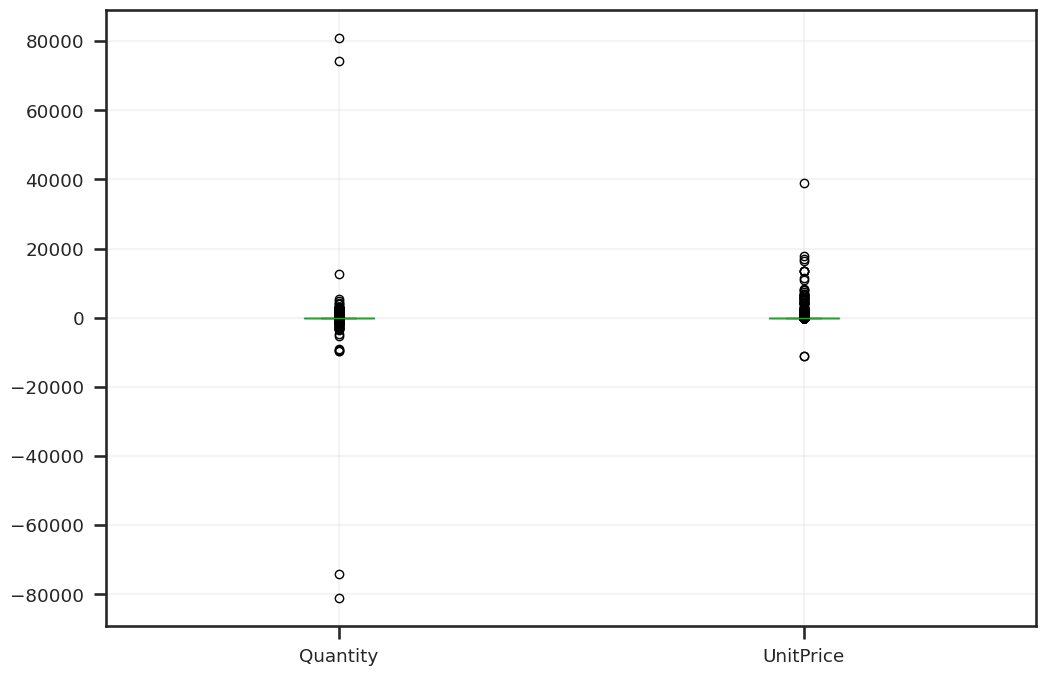

In [ ]:
df[['Quantity', 'UnitPrice']].plot.box()

Podemos observar que há uma quantidade grande de dados negativos que não tem sentido para essa definição, e alguns outliers extremamente fora de um intervalo aceitável.

<Axes: ylabel='Country'>

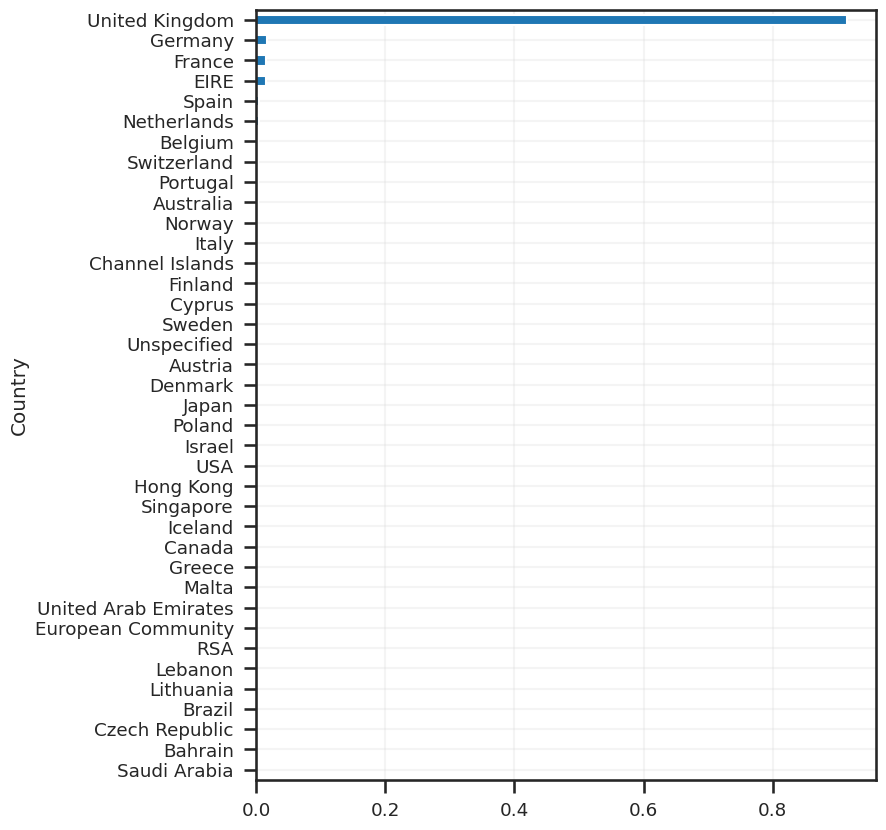

In [ ]:
df['Country'].value_counts(normalize=True, ascending=True).plot.barh(figsize=(8,10))

## Data Preparation

### Data Cleaning

#### Nulos

In [ ]:
df.dropna(subset = 'CustomerID',inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


#### Tipos dos dados

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')
df['CustomerID'] = df.CustomerID.astype(int)
df['Country'] = df['Country'].astype('category')

In [ ]:
df.InvoiceDate.agg(['min','max'])

,InvoiceDate
min,2010-12-01 08:26:00
max,2011-12-09 12:50:00


A base tem entradas de Dez/2010 até Dez/2011


#### Duplicados

In [ ]:
df.duplicated().sum()

5225

In [ ]:
df.drop_duplicates(inplace=True)

#### Outliers

In [ ]:
negativos = df[['Quantity','UnitPrice']].le(0).any(axis=1)
 # le(): menor ou igual ao argumento
df = df[~negativos].copy()

<Axes: >

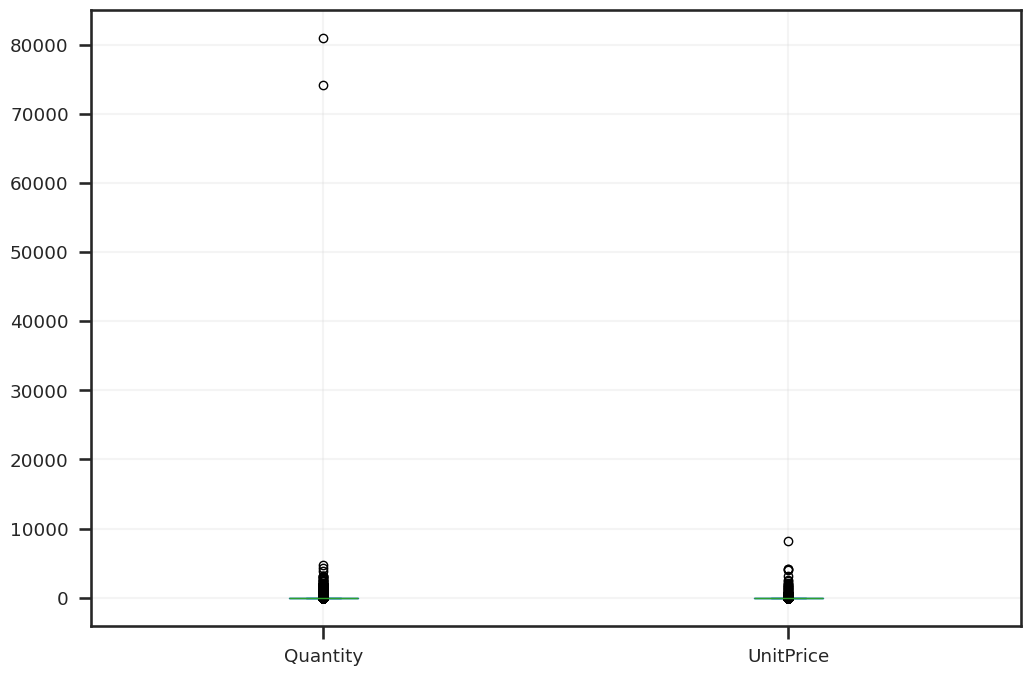

In [ ]:
df[['Quantity','UnitPrice']].plot.box()

<Axes: >

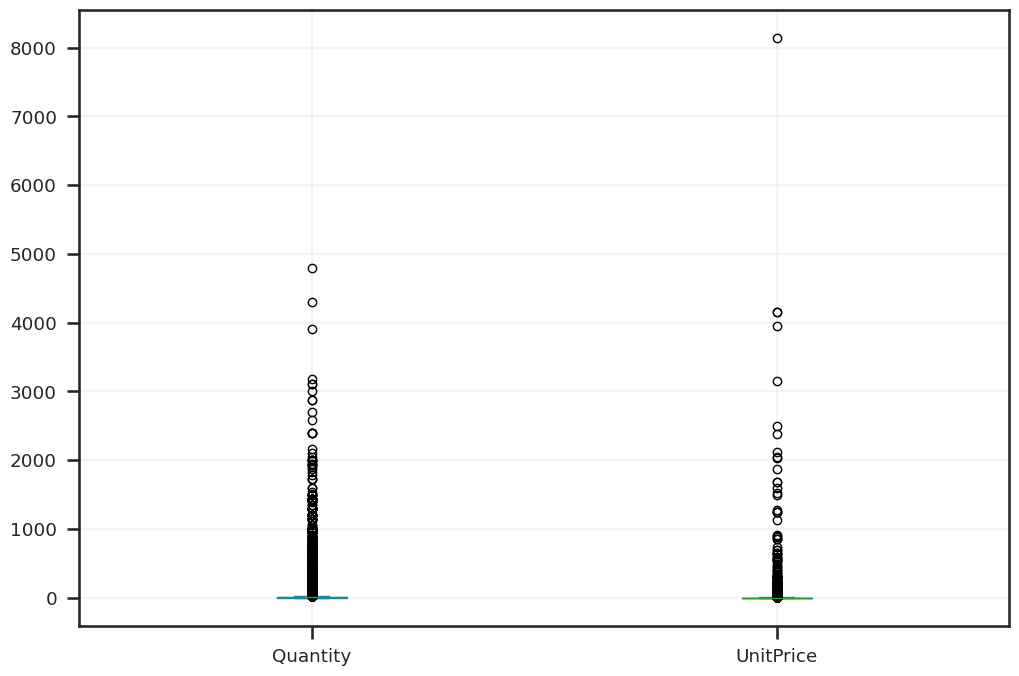

In [ ]:
df.query('Quantity < 7000')[['Quantity','UnitPrice']].plot.box()

<Axes: >

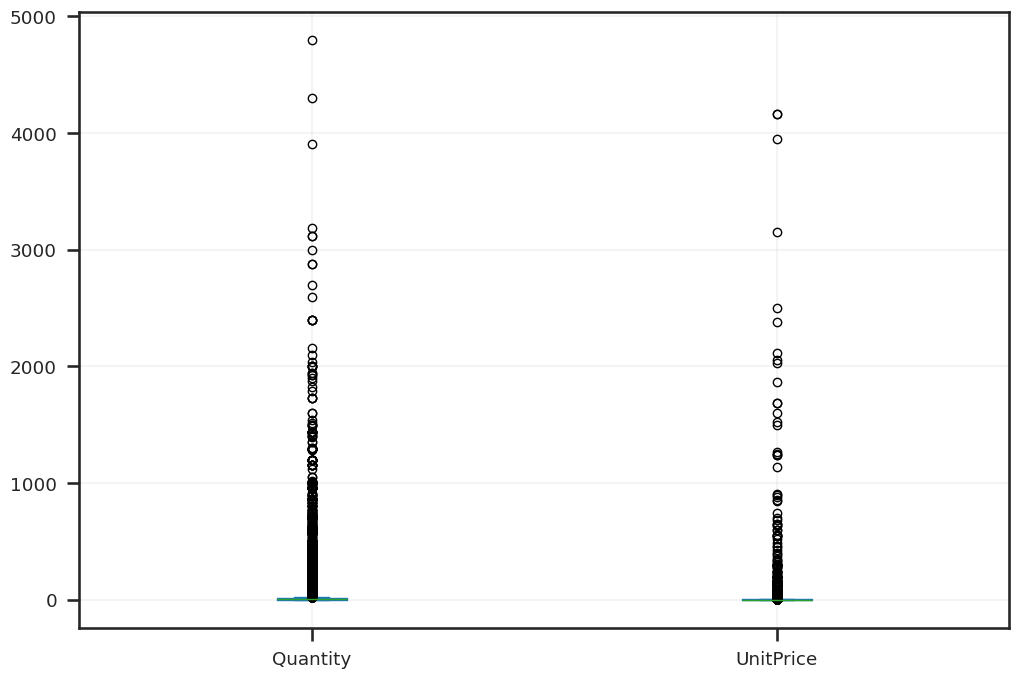

In [ ]:
df.query('Quantity < 7000  & UnitPrice<8_000')[['Quantity','UnitPrice']].plot.box()

In [ ]:
df = df.query('Quantity < 7000  & UnitPrice<8_000').copy()

O restante dos outliers parace estar bem distribuídos e fazem sentido com o tipo de negócio sendo lidado.

### Informalções novas

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [ ]:
df['Price'] = df.Quantity * df.UnitPrice
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


RFM

Para calcular a Recência vamos subtrair a data máxima para cada ID da data de hoje - como a última data registrada na base foi de Dez/2011 vamos utilizar 01/01/2012.\
Para a Frequência vamos contar quantas compras diferentes foram feitas.\
E para Monetary, a média de quanto o cliente gastou.

In [ ]:
today = pd.Timestamp('2012-01-01')

In [ ]:
df_rfm = (
    df.groupby('CustomerID')
    .agg(
        Recency = ('InvoiceDate', lambda x: (today - x.max()).days),
        Frequency = ('InvoiceNo','nunique'),
        Monetary = ('Price','mean')
    )
)
df_rfm

,Recency,Frequency,Monetary
CustomerID,,,
12347,24,7,23.681319
12348,97,4,57.975484
12349,40,1,24.076027
12350,332,1,19.670588
12352,58,8,29.482824
...,...,...,...
18280,299,1,18.060000
18281,202,1,11.545714
18282,29,2,14.837500


#### Data Cleaning

<Axes: >

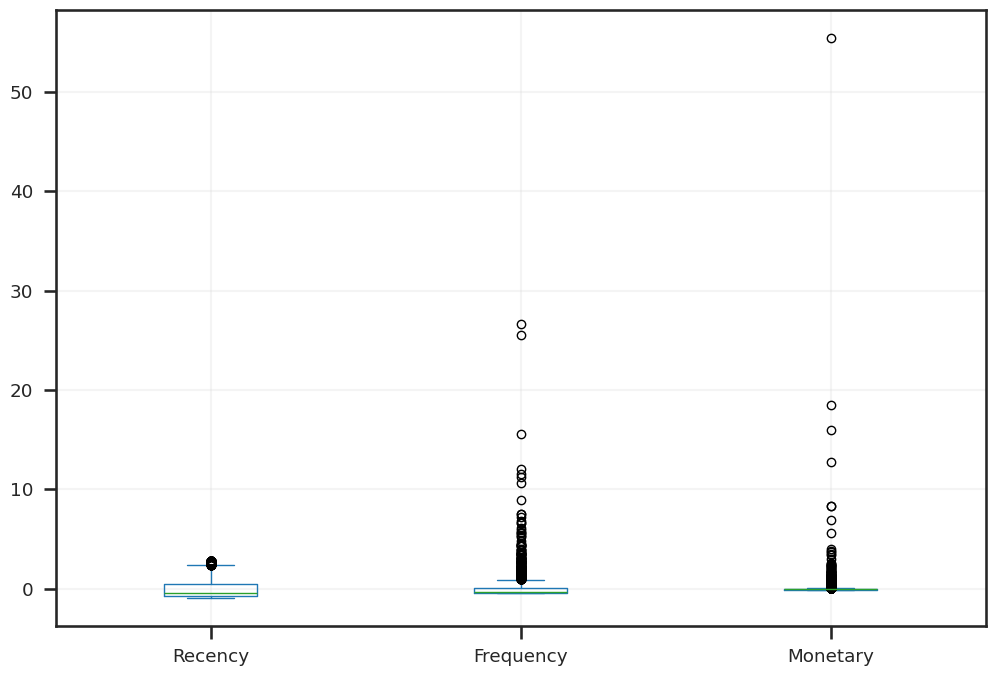

In [ ]:
df_rfm.apply(scale).plot.box()

In [ ]:
df_rfm.apply(scale).query('Monetary > 50')

,Recency,Frequency,Monetary
CustomerID,,,
15098,0.899878,-0.165317,55.434689


In [ ]:
df.query('CustomerID == 15098')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,2011-06-10 15:22:00,4.95,15098,United Kingdom,297.0
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098,United Kingdom,649.5


Para o CustomerID = 15098 os valores parecem muito fora do padrão, então vamos cortá-lo.

In [ ]:
df_rfm.drop(15098, inplace = True)

<Axes: >

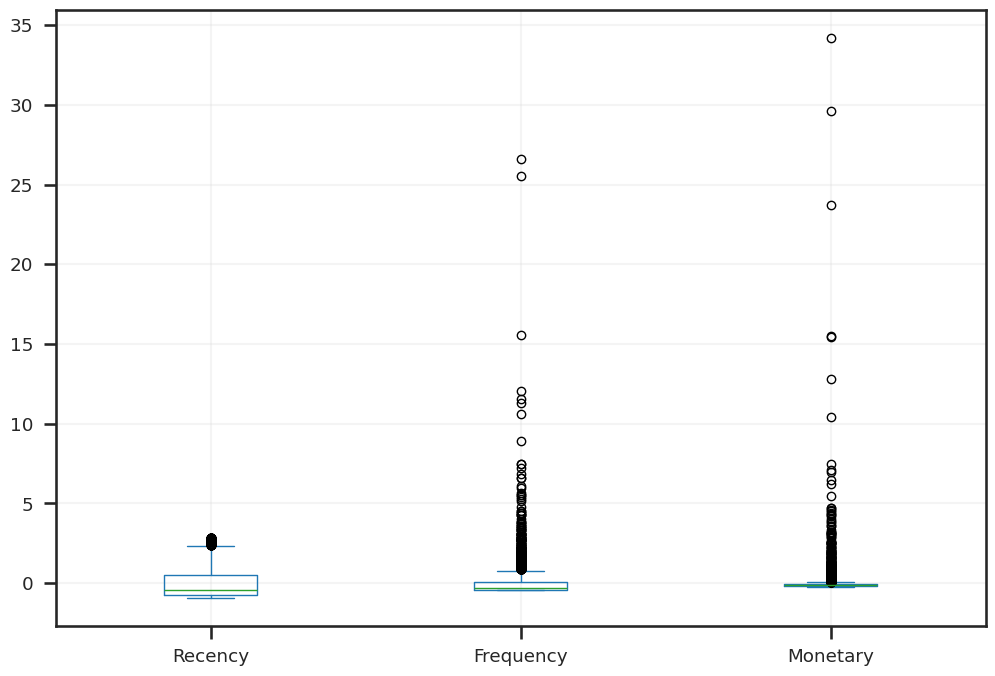

In [ ]:
df_rfm.apply(scale).plot.box()

In [ ]:
df_rfm.describe()

,Recency,Frequency,Monetary
count,4336.000000,4336.000000,4336.000000
mean,114.032288,4.272601,34.585253
std,99.968352,7.697927,129.203857
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.381225
50%,72.000000,2.000000,17.737784
75%,163.250000,5.000000,24.853250
max,395.000000,209.000000,4453.430000


In [ ]:
df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
df_rfm_clip.describe()

,Recency,Frequency,Monetary
count,4336.000000,4336.000000,4336.000000
mean,112.248155,3.608164,23.662082
std,95.504576,3.358999,20.978901
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.381225
50%,72.000000,2.000000,17.737784
75%,163.250000,5.000000,24.853250
max,333.000000,13.000000,91.768421


In [ ]:
df_rfm_clip_scaled = df_rfm_clip.apply(scale)
df_rfm_clip_scaled.describe()

,Recency,Frequency,Monetary
count,4.336000e+03,4.336000e+03,4.336000e+03
mean,-2.130317e-17,1.556770e-17,5.243858e-17
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-9.450706e-01,-7.765601e-01,-1.058904e+00
25%,-7.670481e-01,-7.765601e-01,-5.377860e-01
50%,-4.214751e-01,-4.788181e-01,-2.824257e-01
75%,5.340867e-01,4.144080e-01,5.678586e-02
max,2.311693e+00,2.796344e+00,3.246795e+00


## Modelagem

### K-Means

In [ ]:
# Código das aulas

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,9607.145048,0.481692,1.042416,1534.202439
3,6379.631017,0.395438,0.918546,2250.977458
4,3614.487667,0.479660,0.704316,3752.748844
5,3103.863609,0.386190,0.854429,3454.959599
6,2541.231249,0.397897,0.851011,3566.865109
7,2239.089949,0.402073,0.849264,3470.060263
8,1923.444839,0.390825,0.847351,3563.172646
9,1678.380931,0.400176,0.803116,3651.172116
10,1515.501151,0.351852,0.887849,3645.049413


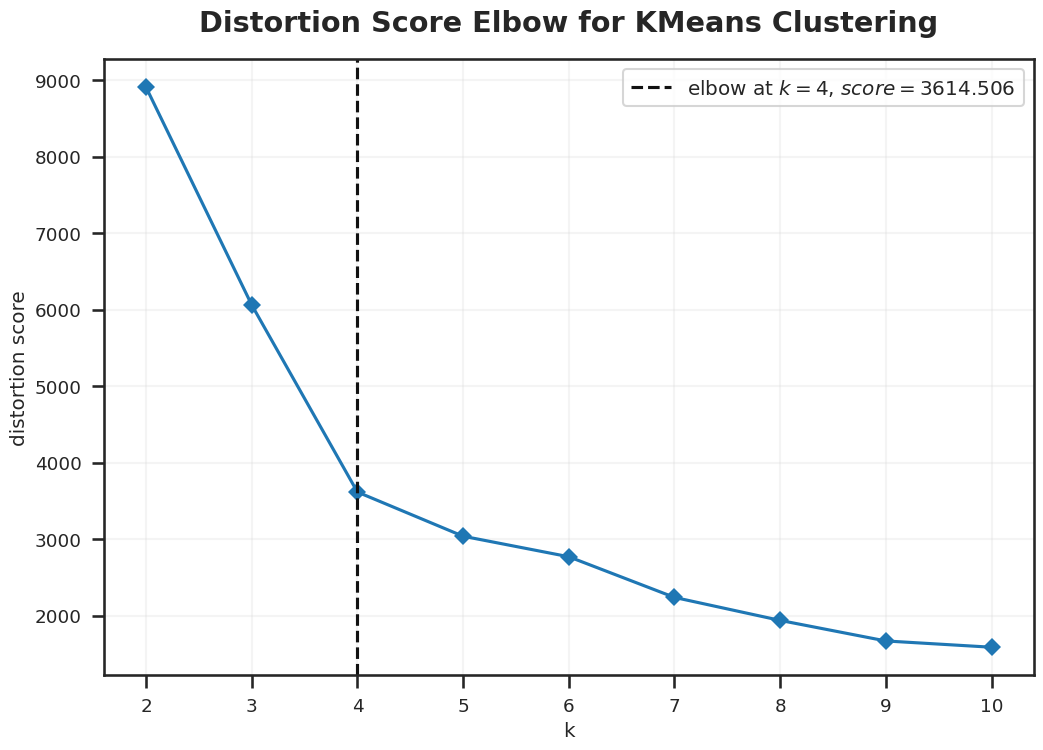

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [ ]:
kelbow_visualizer(KMeans(), df_rfm_clip_scaled, k=10, timings=False)

In [ ]:
kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(df_rfm_clip_scaled)

In [ ]:
px.scatter_3d(df_rfm_clip, x='Recency', y='Frequency', z='Monetary', color=kmeans_labels.astype(str), template='plotly_dark')

In [ ]:
df_rfm_clip['labels']=kmeans_labels
df_rfm_clip

,Recency,Frequency,Monetary,labels
CustomerID,,,,
12347,24,7,23.681319,2
12348,97,4,57.975484,3
12349,40,1,24.076027,0
12350,332,1,19.670588,1
12352,58,8,29.482824,2
...,...,...,...,...
18280,299,1,18.060000,1
18281,202,1,11.545714,1
18282,29,2,14.837500,0


In [ ]:
px.scatter_3d(df_rfm_clip, x='Recency', y='Frequency', z='Monetary', color=df_rfm_clip['labels'].astype(str), template='plotly_dark')

### Hierarchical Clustering

In [ ]:
# Código das aulas

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  #cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.326394,1.464558,1533.770188
3,0.372198,0.979641,2169.014095
4,0.400510,0.829114,2728.753589
5,0.353464,0.847336,2678.245377
6,0.358745,0.901437,2697.226422
7,0.347194,0.941321,2854.244694
8,0.359211,0.880385,3066.658867
9,0.368013,0.821304,3134.134893
10,0.311293,0.893465,3047.509732


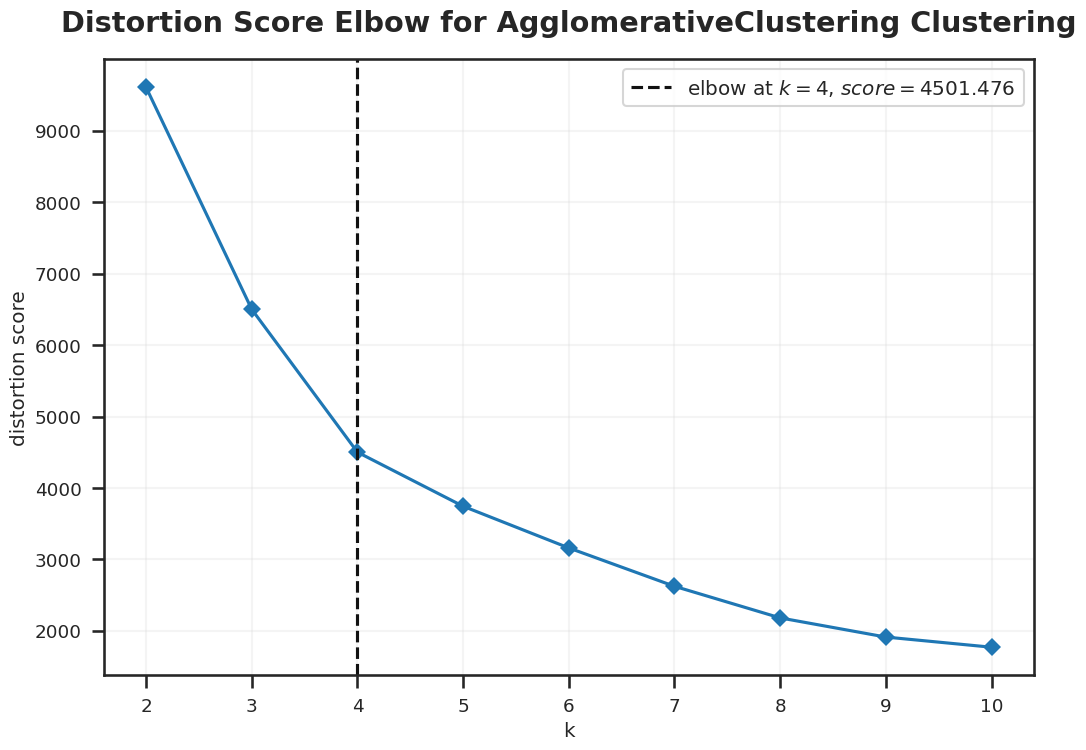

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [ ]:
kelbow_visualizer(AgglomerativeClustering(), df_rfm_clip_scaled, k=10, timings=False)

In [ ]:
hclust = AgglomerativeClustering(n_clusters=4)
hclust_labels = hclust.fit_predict(df_rfm_clip_scaled)

In [ ]:
px.scatter_3d(df_rfm_clip, x='Recency', y='Frequency', z='Monetary', color=hclust_labels.astype(str), template='plotly_dark')

### Gaussian Mixture

In [ ]:
# Select best model by covariance type and K (Practical Statistics for Data Scientists)
results = []
k_range = range(1,9)
covariance_types = ['full', 'tied', 'diag', 'spherical']
X = df_rfm_clip_scaled.copy()

for n_components in k_range:
  for covariance_type in covariance_types:
    mclust = GaussianMixture(n_components=n_components, n_init=10, warm_start=True, covariance_type=covariance_type)
    mclust.fit(X)
    results.append({
      'bic': mclust.bic(X),
      'n_components': n_components,
      'covariance_type': covariance_type,
    })

results = pd.DataFrame(results)
results.sort_values('bic').head()

,bic,n_components,covariance_type
30,-234.643576,8,diag
28,-1.826911,8,full
26,209.878264,7,diag
24,6924.184761,7,full
20,9477.919853,6,full


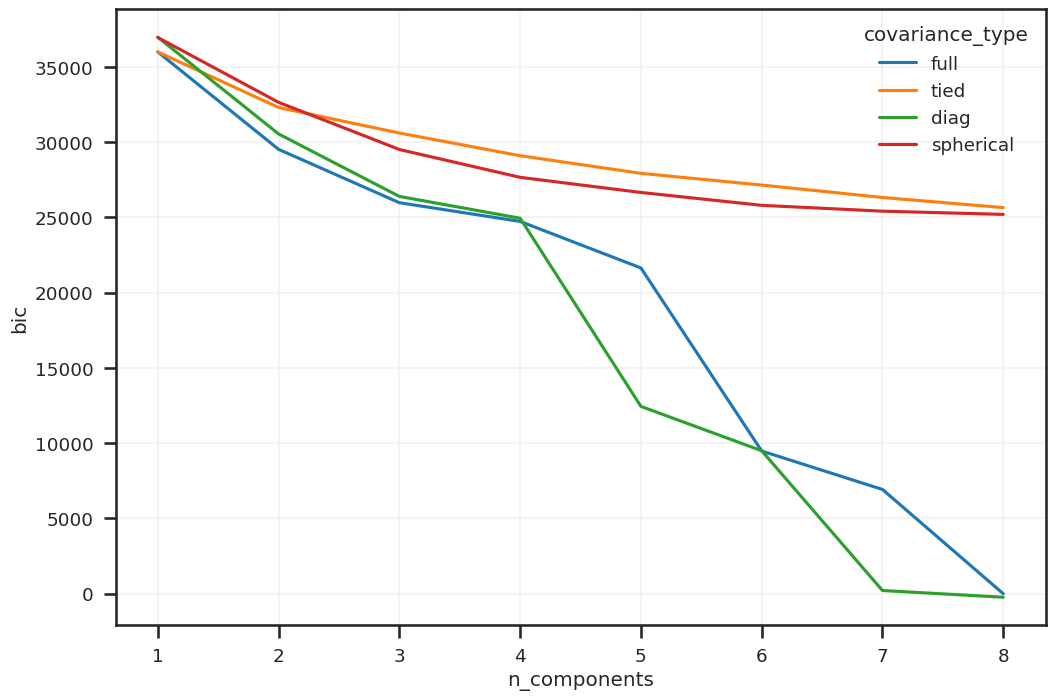

In [ ]:
sns.lineplot(data=results, x='n_components', y='bic', hue='covariance_type');

In [ ]:
mclust = GaussianMixture(n_components=5, covariance_type='full', n_init=10)
mclust_labels = mclust.fit_predict(df_rfm_clip_scaled)

In [ ]:
px.scatter_3d(df_rfm_clip, x='Recency', y='Frequency', z='Monetary', color=mclust_labels.astype(str), template='plotly_dark')

## Interpretação do modelo

**Gaussian Mixture:**\
Mesmo usando os k mais apropriados as divisões ainda não foram tão sastisfatórias para interpretação quanto os outros modelos, isso nos deixa com K-Mean e Hierarchical Clustering.\
\
**Hierarchical Clustering:**\
A divisão está melhor e mais clara que o Gaussian, mas o grupo 1 poderia estar dividido melhor em Monetary, em valores mais baixos e altos como ocorre no K-Means.\
\
**K-Means:**\
Oferece uma divisão entre os clusters mais satisfatória e estão organizados de uma maneira que a sua interpretação tem sentido para o modelo de negócio, portanto é o modelo selecionado.

In [ ]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_clip_scaled.columns)

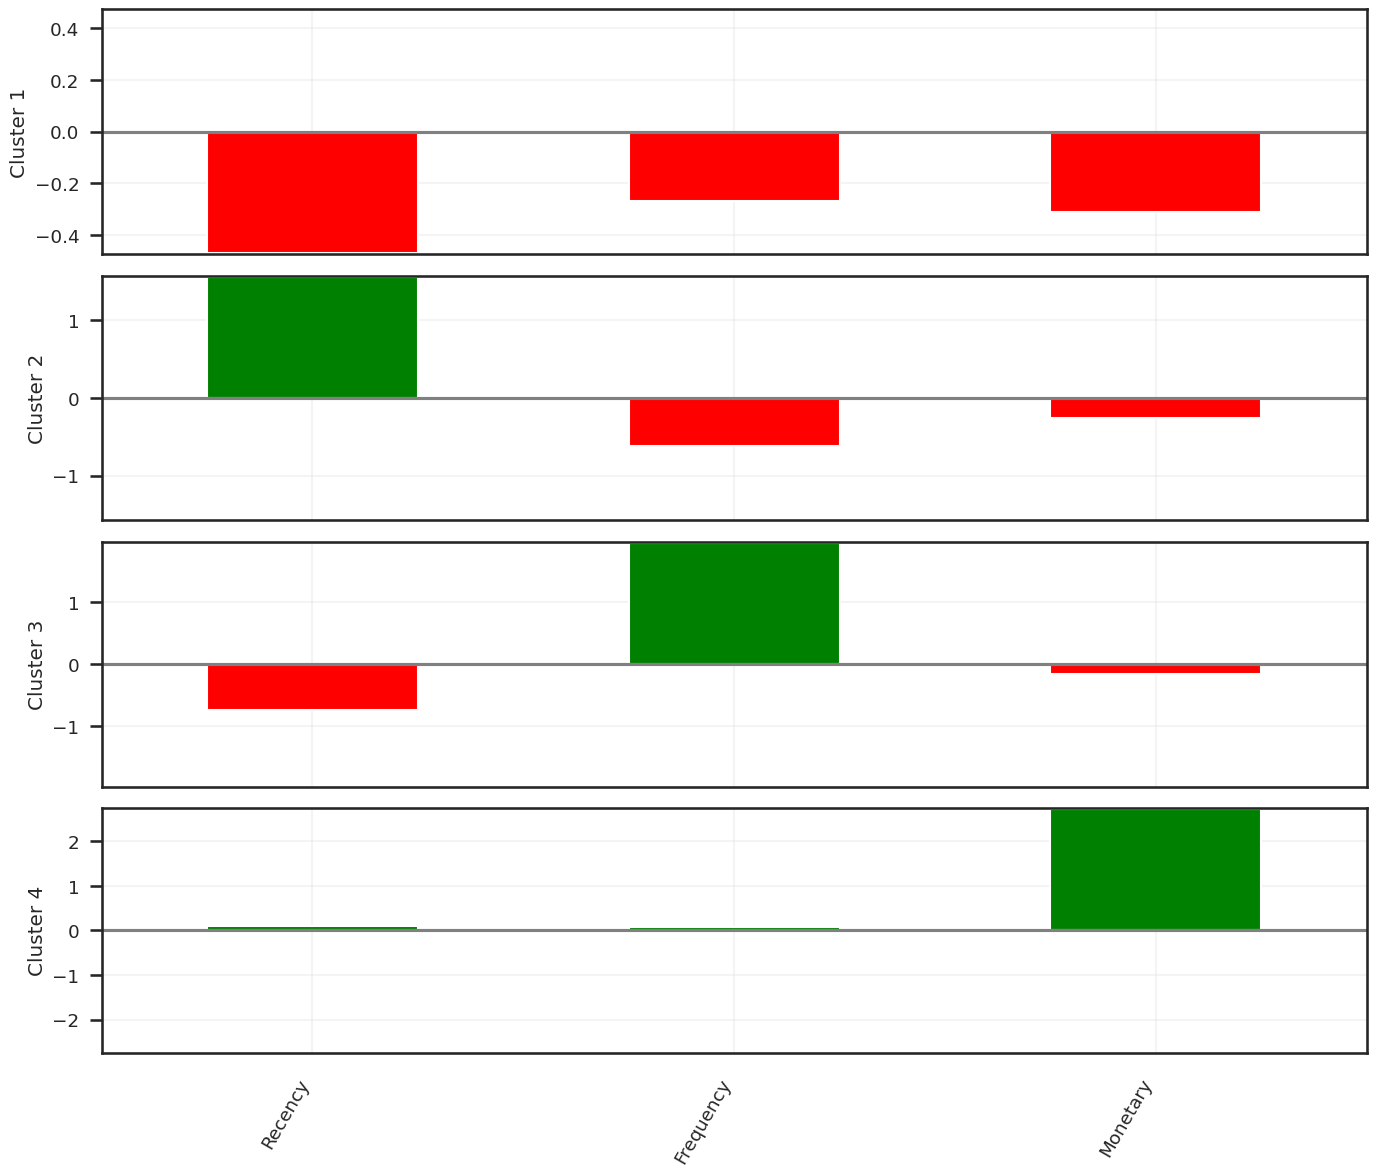

In [ ]:
# Adaptado do livro "Practical Statistics for Data Scientists"
fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

Aqui podemos observar as diferenças entre os clusters e suas características
* Cluster 1: **Ticket médio** mais alto, **frequência** e **Ticket médio** não característicos;
* Cluster 2: Comprou à muito **pouco tempo**, **frequência** e **Ticket médio** mais baixo;
* Cluster 3: Compras mais **frequêntes** e **recentes**, mas **Ticket médio** mais baixo;
* Cluster 4: Não compram tem **muito tempo** e com **pouca frequência** e **Ticket médio** baixo.


In [ ]:
(
  df_rfm_clip.assign(cluster=kmeans_labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)

cluster,0,1,2,3
Recency,67.523221,261.082051,41.517018,121.057935
Frequency,2.703877,1.509744,10.191248,3.876574
Monetary,17.153676,18.121764,20.467061,80.710870


### Escolha

Finalmente, pudemos separar de maneira muito satisfatória os clientes da base de dados com base nas métricas de RFM, os dividindo em 4 grupos.
Um grupo que gasta mais, outro que compra com mais frequência sem gastar muito, um terceiro que não compra com frequência nem gasta muito mas que comprou recentemente, e por último um grupo que também não gasta muito nem com frequência e faz tempo desde a última compra.\
Dessa maneira podemos caracterizar cada cliente e assim oferecer uma nova análise para os Stake Holders tomarem uma decisão muito bem informada sobre os perfis de seus clientes.

Esse tipo de análise para segmentação dos clientes é extremamente útil nas vendas, ao passo que os clientes que gastam pouco por compra mas compram constantemente provavelmente não buscam os mesmos produtos que os cliente que gastam muito com menos frequência. Dessa maneira, podemos propor ofertas e produtos mais direcionados para cada um deles garantindo um percentual de sucesso maior.

## Ações de marketing

Vamos analisar quais produtos tem sido alvo de cada um dos grupos.

In [ ]:
px.scatter_3d(df_rfm_clip, x='Recency', y='Frequency', z='Monetary', color=df_rfm_clip['labels'].astype(str), template='plotly_dark')

In [ ]:
df_labeled = df.join(df_rfm_clip, on='CustomerID')
df_labeled.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price,Recency,Frequency,Monetary,labels
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,333.0,13.0,18.152222,2.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,333.0,13.0,18.152222,2.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,333.0,13.0,18.152222,2.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,333.0,13.0,18.152222,2.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,333.0,13.0,18.152222,2.0


### Cluster 0

Grupo que comprou recentemente, mas não gasta muito nem com frequência.

In [ ]:
df_filter = df_labeled.query('labels == 0')
(
    df_filter.groupby('StockCode')
    .agg(
        Description = ('Description', 'first'),
        Price_mean = ('Price','mean'),
        Frequency_mean = ('Frequency','mean'))
    .sort_values('Price_mean', ascending=False)
    .head(10)
)

,Description,Price_mean,Frequency_mean
StockCode,,,
84968E,SET OF 16 VINTAGE BLACK CUTLERY,262.800000,6.000000
22827,RUSTIC SEVENTEEN DRAWER SIDEBOARD,217.083333,3.916667
22828,REGENCY MIRROR WITH SHUTTERS,206.666667,3.333333
22655,VINTAGE RED KITCHEN CABINET,201.071429,3.500000
22656,VINTAGE BLUE KITCHEN CABINET,183.750000,4.375000
22823,CHEST NATURAL WOOD 20 DRAWERS,156.666667,1.666667
84963B,BLUE PAINTED KASHMIRI CHAIR,149.850000,6.000000
22826,LOVE SEAT ANTIQUE WHITE METAL,141.666667,3.000000
M,Manual,130.017053,3.284211


Tabela com os Top10 produtos mais caros comprados por essa categoria e com qual frequência média.

### Cluster 1

Grupo que não gasta muito nem com frequência, e faz tempo desde a última compra.

In [ ]:
df_filter = df_labeled.query('labels == 1')
(
    df_filter.groupby('StockCode')
    .agg(
        Description = ('Description', 'first'),
        Price_mean = ('Price','mean'),
        Frequency_mean = ('Frequency','mean'))
    .sort_values('Price_mean', ascending=False)
    .head(10)
)

,Description,Price_mean,Frequency_mean
StockCode,,,
22655,VINTAGE RED KITCHEN CABINET,234.000,2.400000
22826,LOVE SEAT ANTIQUE WHITE METAL,167.500,1.500000
22828,REGENCY MIRROR WITH SHUTTERS,165.000,1.000000
22827,RUSTIC SEVENTEEN DRAWER SIDEBOARD,165.000,1.333333
21850,BLUE DIAMANTE PEN IN GIFT BOX,153.000,2.000000
21348,PINK SPOTS CHOCOLATE NESTING BOXES,144.275,3.000000
51008,AFGHAN SLIPPER SOCK PAIR,138.000,1.000000
22823,CHEST NATURAL WOOD 20 DRAWERS,125.000,1.000000
22656,VINTAGE BLUE KITCHEN CABINET,125.000,2.000000


Tabela com os Top10 produtos mais caros comprados por essa categoria e com qual frequência média.

### Cluster 2


Compra com mais frequência mas sem gastar muito.

In [ ]:
df_filter = df_labeled.query('labels == 2')
(
    df_filter.groupby('StockCode')
    .agg(
        Description = ('Description', 'first'),
        Price_mean = ('Price','mean'),
        Frequency_mean = ('Frequency','mean'))
    .sort_values('Frequency_mean', ascending=False)
    .head(10)
)

,Description,Price_mean,Frequency_mean
StockCode,,,
71510,SQUARE METAL CANDLEHOLDER BASE,3.564,13.0
20902,VINTAGE KEEPSAKE BOX PARIS DAYS,9.525,13.0
84712B,PINK JEWELLED PHOTO FRAME,11.925,13.0
90165B,WHITE ROSEBUD PEARL EARRINGS,2.550,13.0
20931,BLUE POT PLANT CANDLE,8.920,13.0
23039,T-LIGHT HOLDER SILVER HEART HANDLE,25.425,13.0
20910,VINTAGE PHOTO ALBUM PARIS DAYS,19.050,13.0
20906,VINTAGE NOTEBOOK BEAUTY GIRL,2.950,13.0
90166,PINK & WHITE ROSEBUD RING,6.275,13.0


Tabela com os Top10 produtos mais frequentemente comprados por essa categoria e com qual preço médio da compra.

### Cluster 3

Grupo que gasta mais.

In [ ]:
df_filter = df_labeled.query('labels == 3')
(
    df_filter.groupby('StockCode')
    .agg(
        Description = ('Description', 'first'),
        Price_mean = ('Price','mean'),
        Frequency_mean = ('Frequency','mean'))
    .sort_values('Price_mean', ascending=False)
    .head(10)
)

,Description,Price_mean,Frequency_mean
StockCode,,,
22053,EMPIRE DESIGN ROSETTE,3202.920000,2.000000
47556B,TEA TIME TEA TOWELS,3022.500000,3.000000
22833,HALL CABINET WITH 3 DRAWERS,2353.680000,13.000000
23461,SWEETHEART BIRD HOUSE,2046.000000,3.000000
21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,1729.057500,9.250000
23046,PAPER LANTERN 9 POINT DELUXE STAR,1380.000000,13.000000
22830,UTILTY CABINET WITH HOOKS,1254.720000,13.000000
22350,ILLUSTRATED CAT BOWL,1234.710000,13.000000
85232B,SET OF 3 BABUSHKA STACKING TINS,1188.000000,13.000000


Tabela com os Top10 produtos mais caros comprados por essa categoria e com qual frequência média.

## Conclusão

A partir dessas listas de produtos os Stake Holders poderiam, por exemplo, dar preferência para promover esses produtos que venderam melhor em cada grupo.